In [1]:
import numpy as np
from PIL import Image, ImageDraw
from IPython import display
from io import BytesIO

import gym
from gym import spaces

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# configure logging
import logging
logger = logging.getLogger()
fhandler = logging.FileHandler(filename='eye-on-stick.log', mode='w')
formatter = logging.Formatter('%(asctime)s %(levelname)s - %(message)s')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.DEBUG)

# suppress trash from PIL and TF
# https://github.com/camptocamp/pytest-odoo/issues/15
logging.getLogger('PIL').setLevel(logging.ERROR)

# https://github.com/hill-a/stable-baselines/issues/298
import os
# https://stackoverflow.com/questions/40426502/is-there-a-way-to-suppress-the-messages-tensorflow-prints/40426709
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import warnings
# https://stackoverflow.com/questions/15777951/how-to-suppress-pandas-future-warning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
import tensorflow as tf
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)
import logging
tf.get_logger().setLevel(logging.ERROR)

In [3]:
def showarray(img_array):
    buf = BytesIO()
    Image.fromarray(np.uint8(img_array)).save(buf, 'png')
    display.display(display.Image(data=buf.getvalue()))

In [4]:
X_LOW = 2
X_HIGH = 3
Y_LOW = -2
Y_HIGH = 2

SCREEN_SIZE = 500
SCREEN_SCALE = SCREEN_SIZE / 7
BG_COLOR = (0, 0, 0)
BORDER_COLOR = (0, 128, 0)

TEXT_COLOR = (128, 128, 128)

CIRCLE_SIZE = 0.05
TARGET_CIRCLE_COLOR = (255, 0, 0)        
EYE_CIRCLE_COLOR = (0, 0, 255)
BASE_CIRCLE_COLOR = (0, 255, 0)

STICK_LEN = 1.0
STICK_WIDTH = 0.01
STICK_COLOR = (128, 128, 128)

PHI_MIN = -np.pi/2
PHI_MAX = np.pi/2
DPHI = np.pi/360
ALPHA_GOAL = 2*DPHI

MAX_STEPS = 100

MODEL_FNAME = "eye-on-stick"

In [5]:
class EyeOnStickEnv(gym.Env):    
    metadata = {'render.modes': ['rgb_array']}
    
    ACC_PLUS = 2
    ACC_ZERO = 1
    ACC_MINUS = 0
    
    def __init__(self):
        super(EyeOnStickEnv, self).__init__()
        self.base_x = 0
        self.base_y = 0
        self.stick_len = 1.0

        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-1, high=1, shape=(3,), dtype=np.float32)
        
        self.nresets = 0
        self.nsteps = 0
    
    def reset(self):
        self.nresets += 1
        self.nsteps = 0
        self.actions_log = ""

        # set random target location
        self.target_x = np.random.uniform(low=X_LOW, high=X_HIGH)
        self.target_y = np.random.uniform(low=Y_LOW, high=Y_HIGH)
        self.phi_k = np.random.uniform(low=0.75, high=1.25)
        
        # the stick is randomly oriented, but stationary
        self.phi = np.random.uniform(low=PHI_MIN, high=PHI_MAX)
        self.dphi = 0
        
        self._recalc()
        
        return self.get_obs()
    
    def _recalc(self):    
        # eye observes target as projection on retina
        self.eye_x = self.stick_len * np.cos(self.phi)
        self.eye_y = self.stick_len * np.sin(self.phi)
        self.eye_phi = self.phi
        
        dx = self.target_x - self.eye_x
        dy = self.target_y - self.eye_y
        self.alpha = np.arctan2(dy, dx) - self.eye_phi
              
    def get_obs(self):
        return np.array([np.sin(self.alpha), np.cos(self.alpha), self.dphi]).astype(np.float32)
    
    def step(self, action):
        self.nsteps += 1

        if action == self.ACC_PLUS:
            self.dphi += 1
            action_char = '+'
        elif action == self.ACC_MINUS:
            self.dphi -= 1
            action_char = '-'
        elif action == self.ACC_ZERO:
            action_char = 'o'
        else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))

        self.actions_log += action_char
        if len(self.actions_log) % 50 == 0:
            self.actions_log += '\n'

        self.phi += self.dphi * DPHI * self.phi_k
        if self.phi > PHI_MAX:
            self.phi = PHI_MAX
            self.dphi = 0
        elif self.phi < PHI_MIN:
            self.phi = PHI_MIN
            self.dphi = 0
            
        self._recalc()
        
        done = bool(np.abs(self.alpha) <= ALPHA_GOAL)
        reward = 10 if done else 0
        info = {}
        
        return self.get_obs(), reward, done, info


    def render(self, mode='rgb_array'):
        if mode != 'rgb_array':
            raise NotImplementedError()

        image = Image.new('RGB', (SCREEN_SIZE, SCREEN_SIZE), BG_COLOR)
        draw = ImageDraw.Draw(image)
        draw.polygon([
            (0, 0),
            (0, SCREEN_SIZE-1),
            (SCREEN_SIZE-1, SCREEN_SIZE-1),
            (SCREEN_SIZE-1, 0),
            (0, 0)
        ], outline=BORDER_COLOR)
            
        def draw_circle(x, y, r, fill):
            px = int(SCREEN_SIZE / 2 + x * SCREEN_SCALE)
            py = int(SCREEN_SIZE / 2 + y * SCREEN_SCALE)
            pr = int(r * SCREEN_SCALE)
            draw.ellipse((px - pr, py - pr, px + pr, py + pr), fill=fill)        

        def draw_line(x1, y1, x2, y2, fill, w):
            px1 = int(SCREEN_SIZE / 2 + x1 * SCREEN_SCALE)
            py1 = int(SCREEN_SIZE / 2 + y1 * SCREEN_SCALE)
            px2 = int(SCREEN_SIZE / 2 + x2 * SCREEN_SCALE)
            py2 = int(SCREEN_SIZE / 2 + y2 * SCREEN_SCALE)
            pw = int(w * SCREEN_SCALE)
            draw.line((px1, py1, px2, py2), fill=fill, width=pw)

        def draw_text(pos, txt):
            draw.text(pos, txt, fill=TEXT_COLOR)
            
        draw_text((10, 10), "round %d, step %d" % (self.nresets, self.nsteps))
        draw_text((10, 20), "phi_k %.3f, phi %.3f, dphi %.3f, alpha %.3f (goal %.3f)" % (self.phi_k, self.phi, self.dphi, self.alpha, ALPHA_GOAL))
        draw_text((10, 30), self.actions_log)
            
        dx = self.stick_len * np.cos(self.eye_phi)
        dy = self.stick_len * np.sin(self.eye_phi)
        draw_circle(self.base_x, self.base_y, CIRCLE_SIZE, BASE_CIRCLE_COLOR)
        draw_line(self.base_x, self.base_y, self.base_x + dx, self.base_y + dy, STICK_COLOR, STICK_WIDTH)
        draw_circle(self.eye_x, self.eye_y, CIRCLE_SIZE, EYE_CIRCLE_COLOR)
        draw_circle(self.target_x, self.target_y, CIRCLE_SIZE, TARGET_CIRCLE_COLOR)
               
        return np.asarray(image)

    def close(self):
        pass

In [6]:
#eos = EyeOnStickEnv()
#eos.reset()
#eos.get_obs()
#eos.step(1)
#plt.imshow(eos.render())

In [7]:
from stable_baselines.common.cmd_util import make_vec_env
from stable_baselines.common.vec_env import VecNormalize

N_ENVS = 32
env = make_vec_env(lambda: EyeOnStickEnv(), n_envs=N_ENVS)
env = VecNormalize(env)

In [8]:
#from stable_baselines import ACKTR
#model = ACKTR('MlpLstmPolicy', env, verbose=1)
from stable_baselines import PPO2

try:
    model = PPO2.load(MODEL_FNAME)
except ValueError as ex:
    model = PPO2('MlpLnLstmPolicy', env, verbose=1)

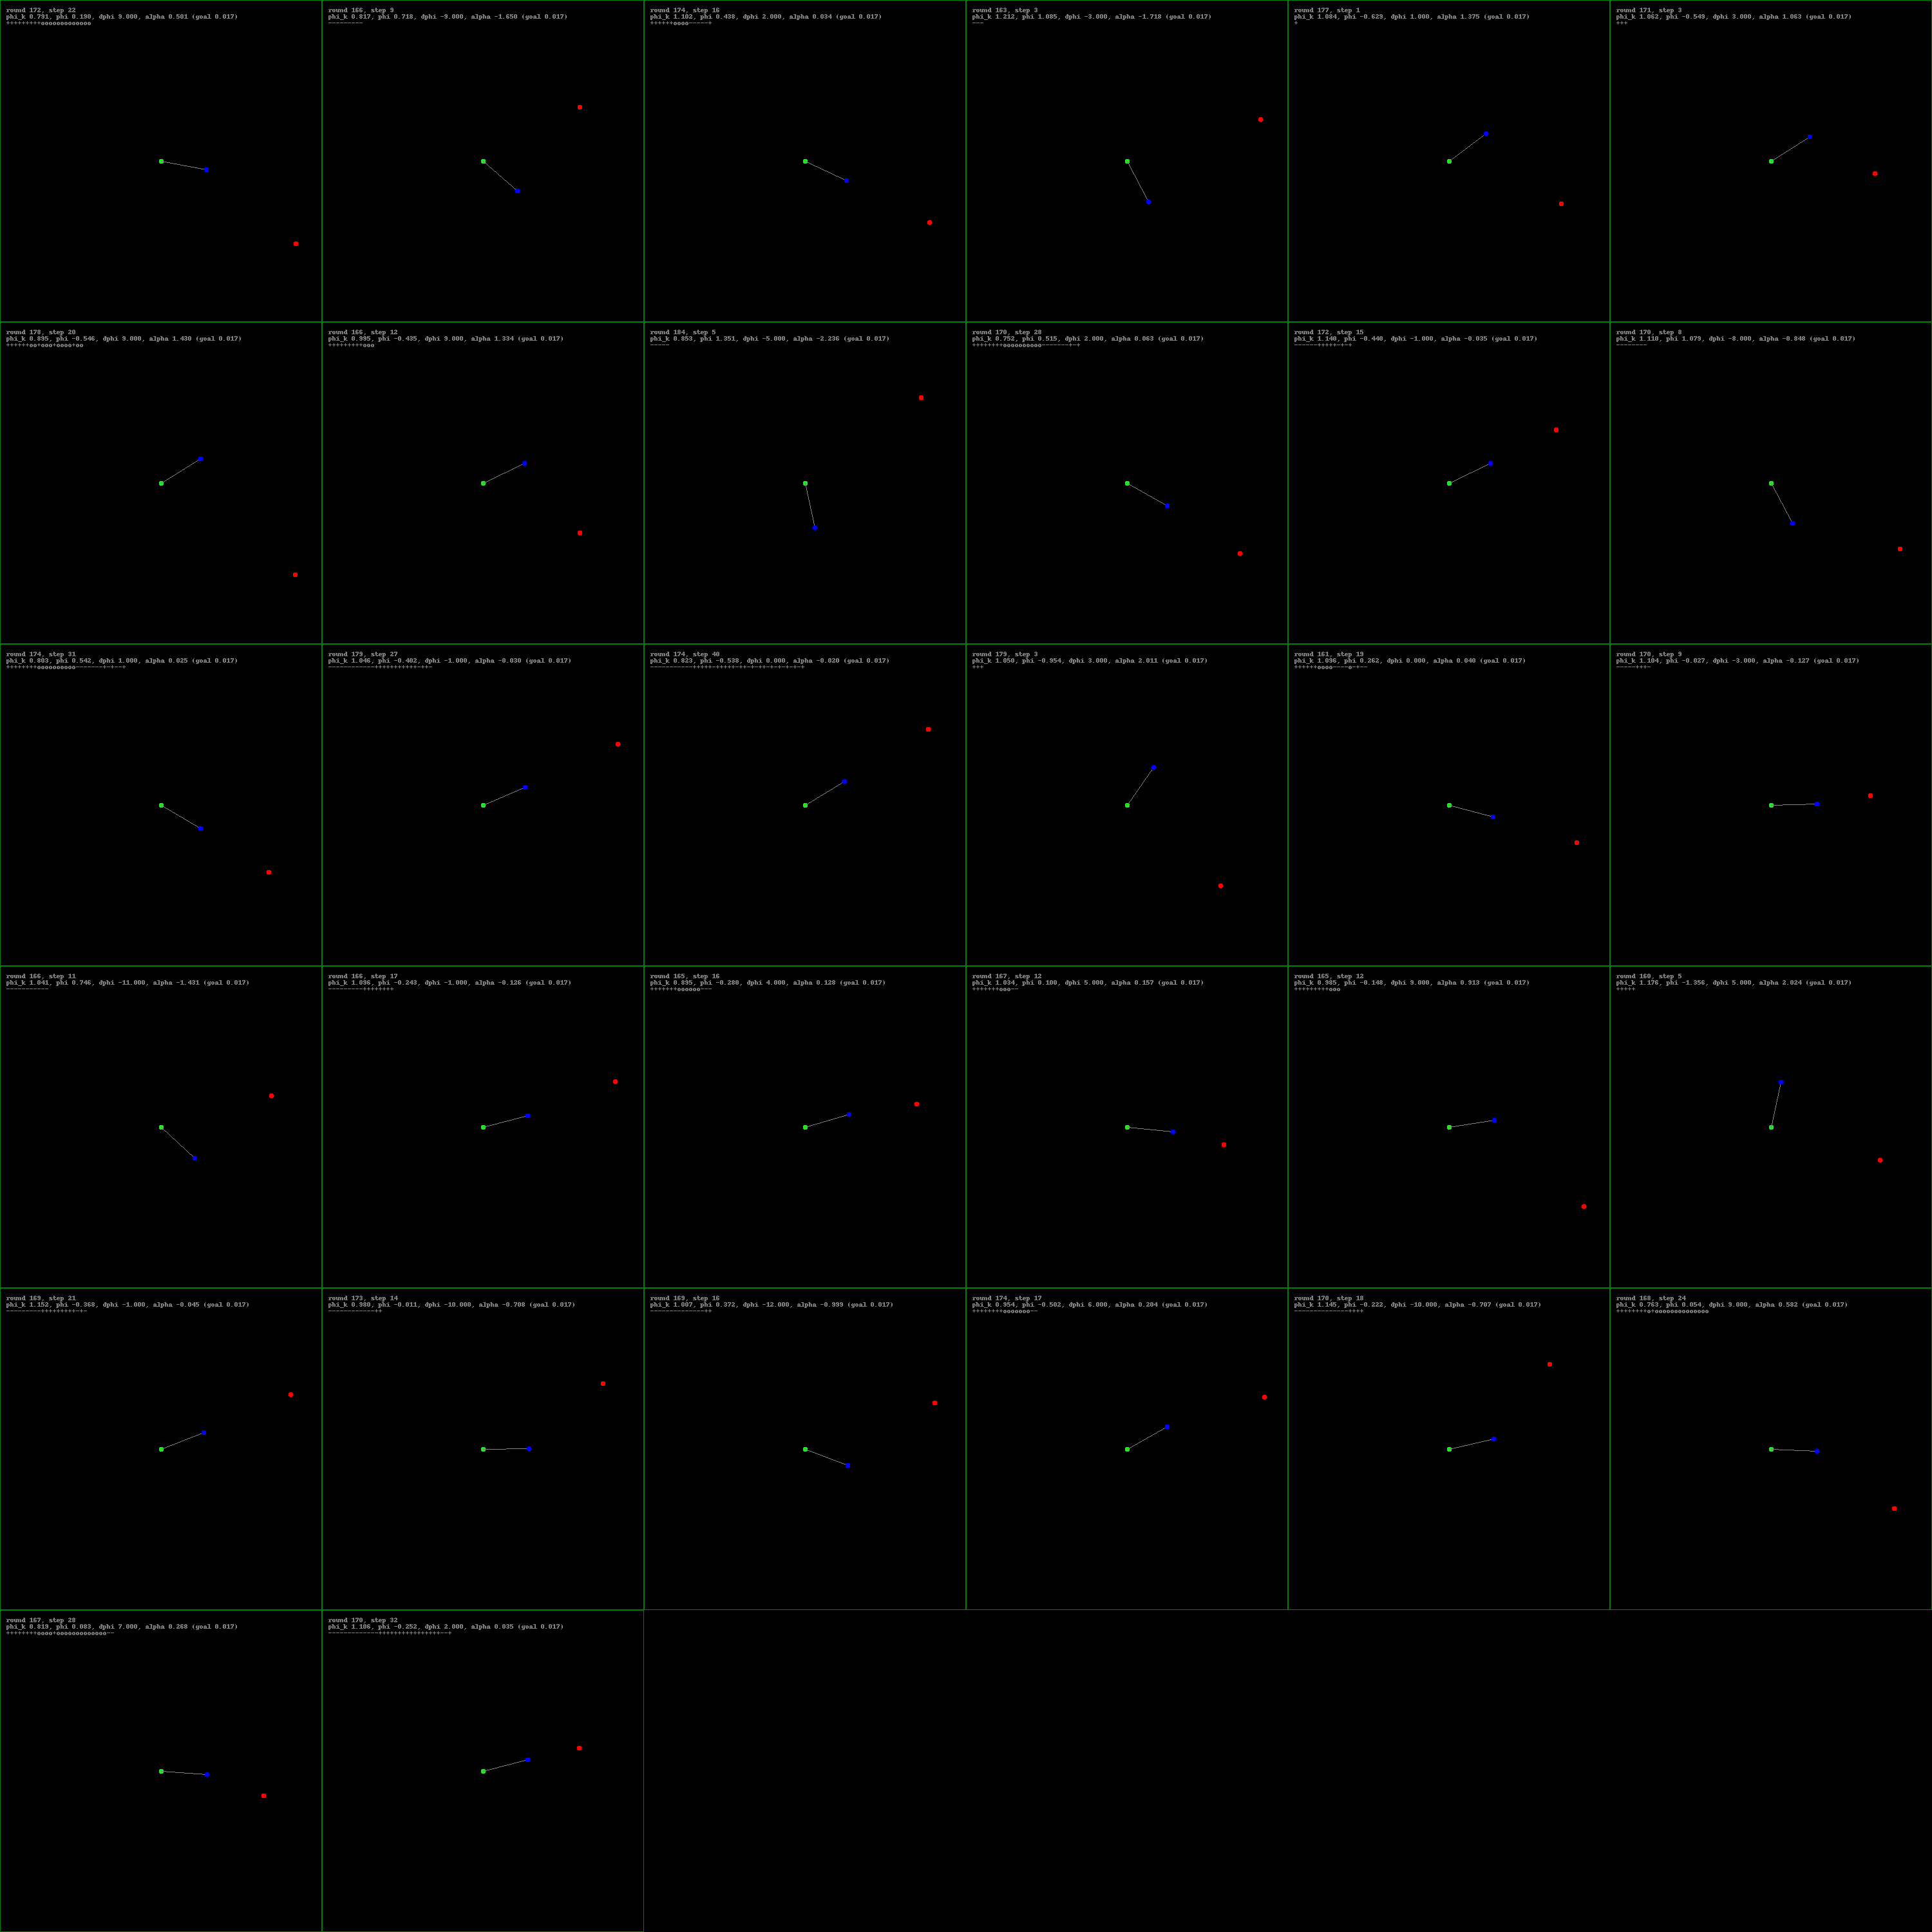

In [ ]:
while True:   
    n_victories, n_losses = 0, 0
    n_steps = np.zeros(N_ENVS)
    
    obs = env.reset()

    while n_losses == 0:
        display.clear_output(wait=True)
        showarray(env.render(mode='rgb_array'))

        actions, _ = model.predict(obs, deterministic=True)
        obs, _, dones, _ = env.step(actions)
        
        for i, done in enumerate(dones):
            if done:
                logger.debug("[%2d] goal reached after %d steps (%d victories)" % (i, n_steps[i], n_victories))
                n_victories += 1
                n_steps[i] = 0
                n_steps_since_done = 0
            if n_steps[i] > MAX_STEPS:
                logger.debug("[%2d] goal not reached after %d steps" % (i, n_steps[i]))
                n_losses += 1
                
        n_steps += 1
        
    n_learn_epochs = 2000 * N_ENVS
    logger.debug("%d victories, %d losses, back to school for %d epochs ..." % (n_victories, n_losses, n_learn_epochs))
    model.learn(n_learn_epochs)
    model.save(MODEL_FNAME)
    logger.debug("learning completed, model saved in %s" % (MODEL_FNAME))

env.close()